In [9]:
import pandas as pd
pd.set_option('display.max_columns', None)
import sys, os
sys.path.append( '..' )
from script.utils import *
from Class.PlotConfig import *

In [44]:
raw_dataset = '../../dataset_raw/CovidMay17-2022/'
df = pd.read_csv(os.path.join(raw_dataset, 'Cases.csv'))

df = convert_cumulative_to_daily(df)
merge_keys = ['FIPS', 'Date']
feature = "Cases"

In [1]:
# import pandas as pd
# df = pd.read_csv('../2022_May_cleaned_moving_averaged/Total.csv')

# for target in ['Cases', 'Deaths']:
#     temp = df[['FIPS', 'Date',target]].pivot(index='FIPS',columns="Date", values=target).reset_index()
#     fips = temp['FIPS'].values
#     temp.drop(columns=['FIPS'], inplace=True)
#     temp = temp.cumsum(axis=1)
#     date_columns = list(temp.columns)

#     temp['FIPS'] = fips
#     temp = temp[['FIPS']+date_columns]
#     temp.round(1).to_csv(f'{target}.csv', index=False)

In [45]:
cleaned_0 = remove_outliers(df, multiplier=7.5)
cleaned_1 = remove_outliers(df, multiplier=3)

Outliers found 86834, percent 3.232
Outliers found 181297, percent 6.749


In [46]:
id_vars = [col for col in df.columns if not valid_date(col)]

def convert(df, feature='Cases'):
    df = df.melt(
        id_vars= id_vars,
        var_name='Date', value_name=feature
    ).reset_index(drop=True)
    
    df['Date'] = to_datetime(df['Date'])
    first_date = to_datetime('02-29-2020')
    last_date = to_datetime('05-17-2022')
    
    df = df[(first_date <= df['Date']) & (df['Date']<= last_date)]

    df.loc[df[feature]<0, feature] = 0
    
    return df

In [47]:
df = convert(df)
cleaned_0 = convert(cleaned_0)
cleaned_1 = convert(cleaned_1)

In [15]:
description = df[feature].describe().reset_index()
description
for index, cleaned in enumerate([cleaned_0, cleaned_1]):
    desc = cleaned[feature].describe().reset_index()
    desc.rename({feature:f'{feature}_{index}'}, axis=1, inplace=True)
    description = description.merge(desc, on='index', how='inner')

description

,index,Cases,Cases_0,Cases_1
0,count,2.570156e+06,2.570156e+06,2.570156e+06
1,mean,3.164205e+01,2.716180e+01,2.356405e+01
2,std,3.368481e+02,1.744197e+02,1.281488e+02
3,min,0.000000e+00,0.000000e+00,0.000000e+00
4,25%,0.000000e+00,0.000000e+00,0.000000e+00
5,50%,1.000000e+00,1.000000e+00,1.000000e+00
6,75%,1.200000e+01,1.100000e+01,1.100000e+01
7,max,1.864080e+05,2.061825e+04,9.861000e+03


In [16]:
def plot_distribution(df, title:str=None, feature:str='Cases', scale:int=1e3):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    if title is not None:
        plt.suptitle(title)

    axes[0].violinplot(df[feature], vert=False)
    axes[1].hist(df[feature])

    # sns.violinplot(x=cleaned_0[feature], ax=axes[0])
    # df[feature].plot(kind='hist', ax=axes[1], bins=10)
    # df[feature].plot(kind='kde', ax=axes[1], secondary_y=True)

    ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale))
    if scale==1e3: unit = 'in thousands'
    elif scale==1e6: unit = 'in millions'
    else: unit = f'x {scale:.0e}'

    for ax in axes:
        ax.xaxis.set_major_formatter(ticks_x)
        ax.set_xlabel(f'{feature} ({unit})')

    plt.tight_layout()
    plt.show()

## County wide distribution

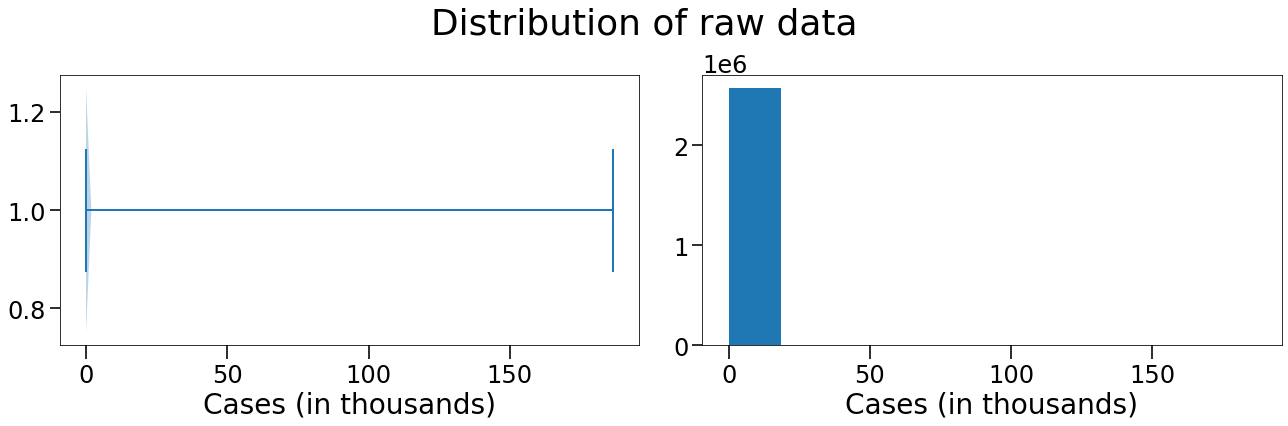

In [17]:
plot_distribution(df, 'Distribution of raw data')

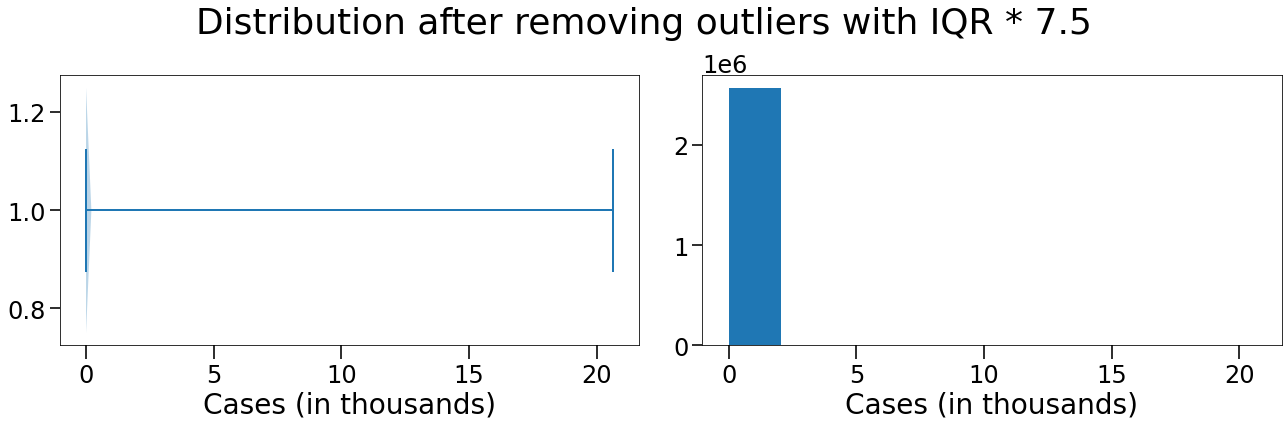

In [12]:
plot_distribution(cleaned_0, 'Distribution after removing outliers with IQR * 7.5')

## Summed distribution

In [2]:
def sum_up(df):
    return df.groupby('Date')[[feature]].aggregate('sum').reset_index()

In [48]:
df = sum_up(df)
cleaned_0 = sum_up(cleaned_0)
cleaned_1 = sum_up(cleaned_1)

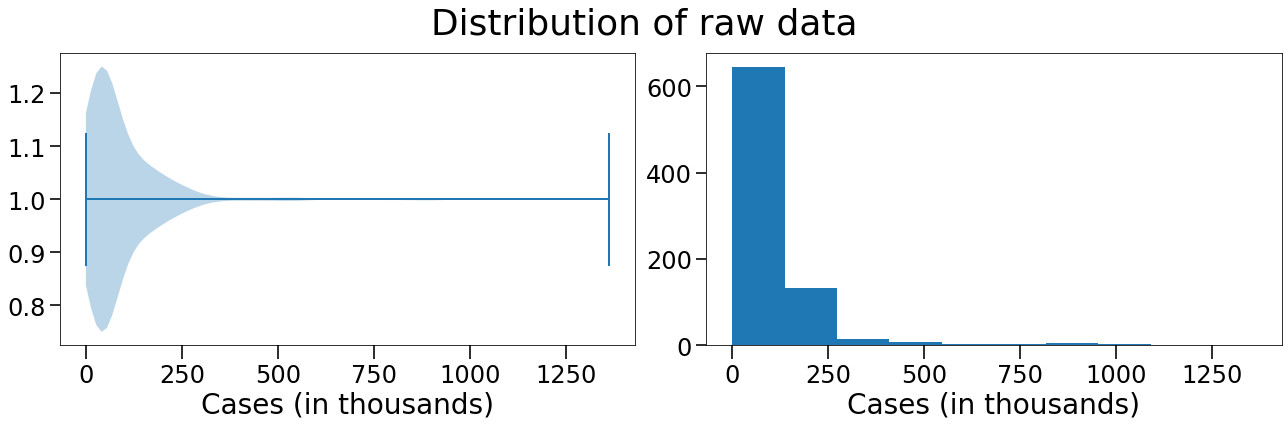

In [19]:
plot_distribution(df, 'Distribution of raw data')

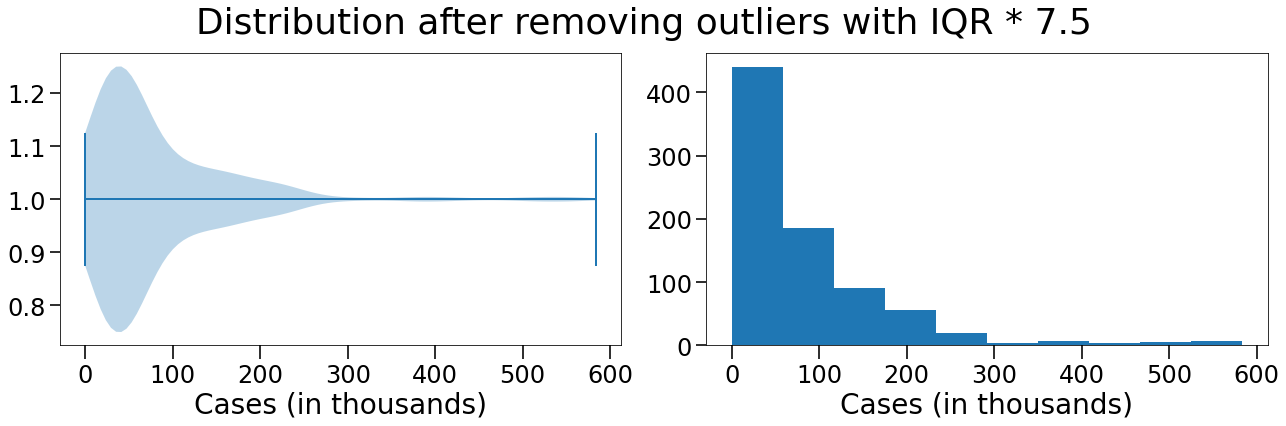

In [20]:
plot_distribution(cleaned_0, 'Distribution after removing outliers with IQR * 7.5')

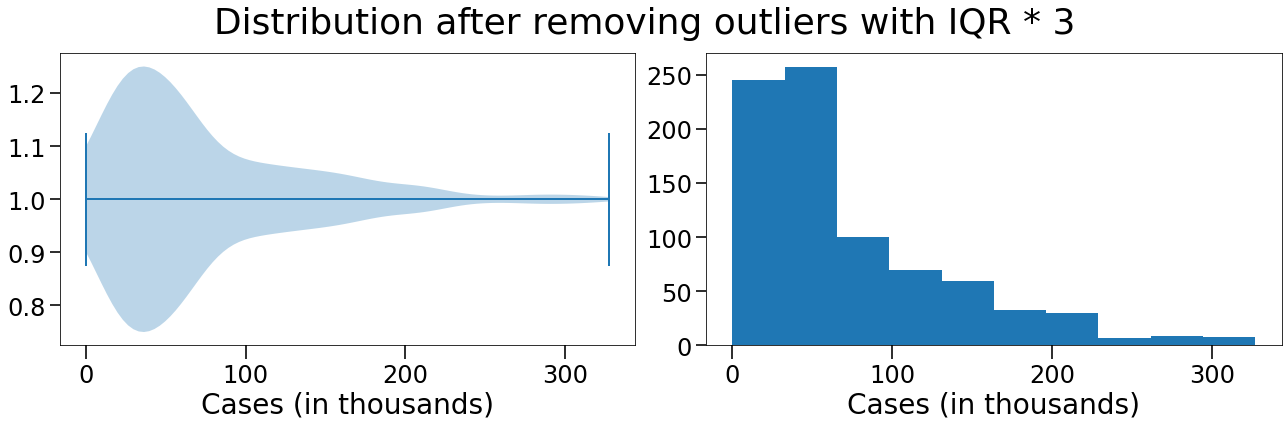

In [17]:
plot_distribution(cleaned_1, 'Distribution after removing outliers with IQR * 3')

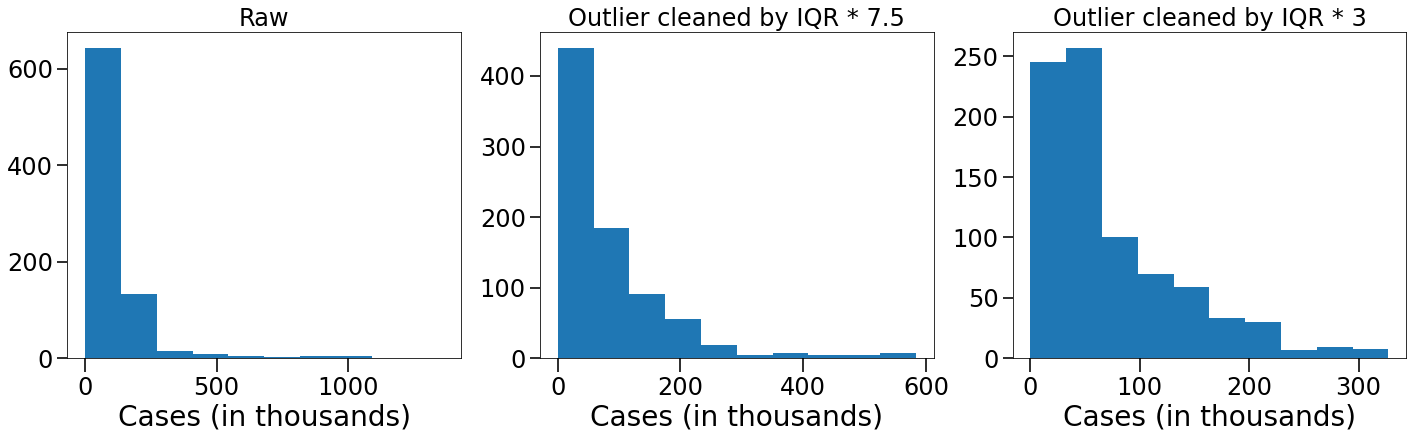

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))

axes[0].hist(df[feature]); axes[0].set_title('Raw')
axes[1].hist(cleaned_0[feature]); axes[1].set_title('Outlier cleaned by IQR * 7.5')
axes[2].hist(cleaned_1[feature]); axes[2].set_title('Outlier cleaned by IQR * 3')

scale = 1e3
ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale))
if scale==1e3: unit = 'in thousands'
elif scale==1e6: unit = 'in millions'
else: unit = f'x {scale:.0e}'

for ax in axes:
    ax.xaxis.set_major_formatter(ticks_x)
    ax.set_xlabel(f'{feature} ({unit})')

plt.show()

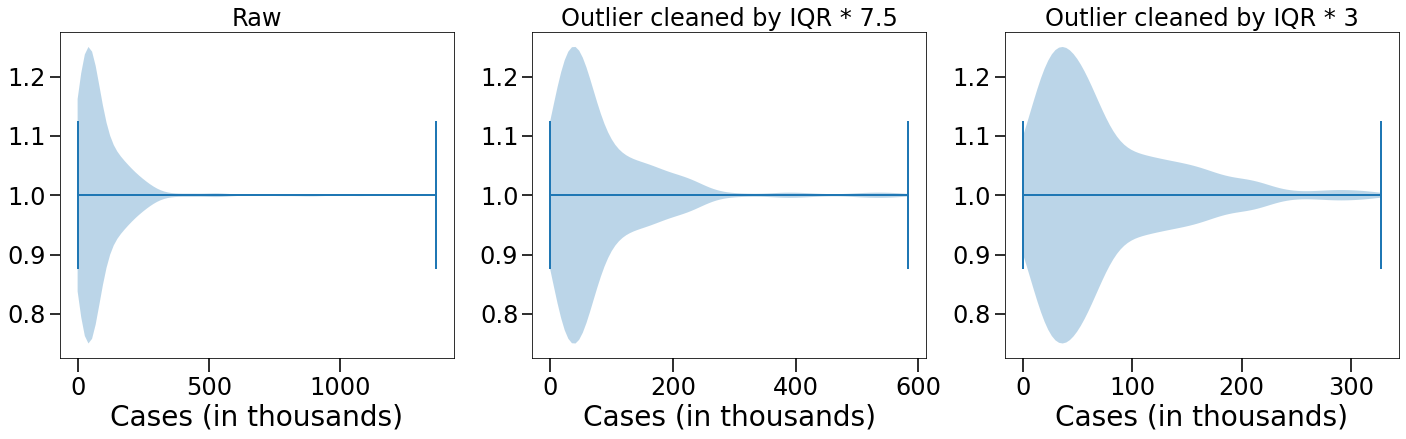

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))

axes[0].violinplot(df[feature], vert=False); axes[0].set_title('Raw')
axes[1].violinplot(cleaned_0[feature], vert=False); axes[1].set_title('Outlier cleaned by IQR * 7.5')
axes[2].violinplot(cleaned_1[feature], vert=False); axes[2].set_title('Outlier cleaned by IQR * 3')

scale = 1e3
ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale))
if scale==1e3: unit = 'in thousands'
elif scale==1e6: unit = 'in millions'
else: unit = f'x {scale:.0e}'

for ax in axes:
    ax.xaxis.set_major_formatter(ticks_x)
    ax.set_xlabel(f'{feature} ({unit})')

plt.show()

# Individual Plots

## Util

In [3]:
figPath = '../results/'

def plot(df, target, title:str=None, scale_y:int=1e3, x_major_ticks:int=DATE_TICKS, figure_name:str=None):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    x_column = 'Date'
    if title is not None:
        plt.title(title)

    plt.plot(df[x_column], df[target])
    plt.ylim(bottom=0)

    x_first_tick = df[x_column].min()
    x_last_tick = df[x_column].max()
    ax.set_xticks(
        [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
    )
    plt.xticks(rotation = 45)
        
    if scale_y > 1:
        ax.yaxis.set_major_formatter(get_formatter(scale_y))
        
        if scale_y==1e3: unit = 'in thousands'
        elif scale_y==1e6: unit = 'in millions'
        else: unit = f'x {scale_y:.0e}'

        plt.ylabel(f'Daily {target} ({unit})')
    else:
        plt.ylabel(f'Daily {target}')

    # fig.tight_layout() # might change y axis values

    if figure_name is not None:
        plt.savefig(os.path.join(figPath, figure_name), dpi=DPI)
    plt.show()

## Plots

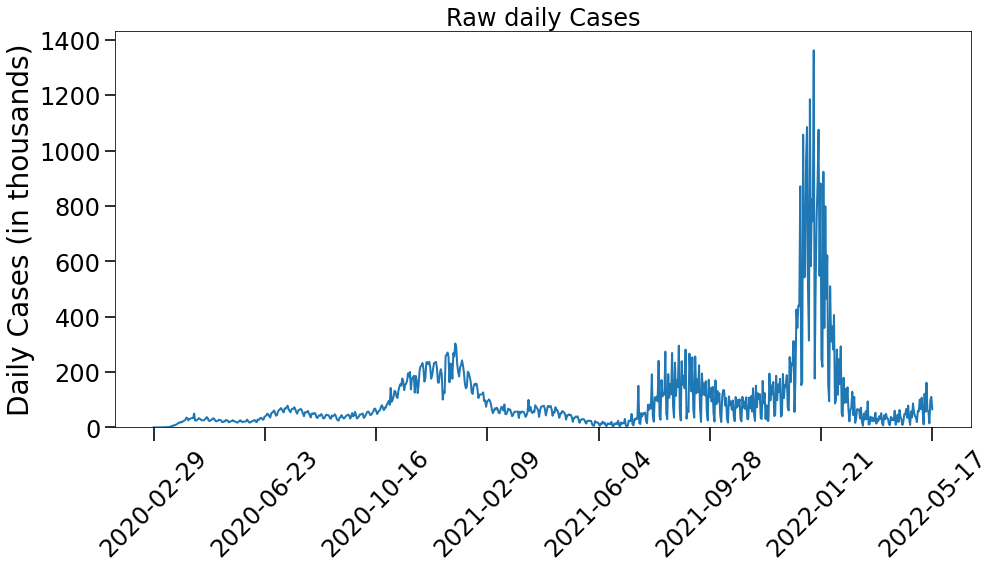

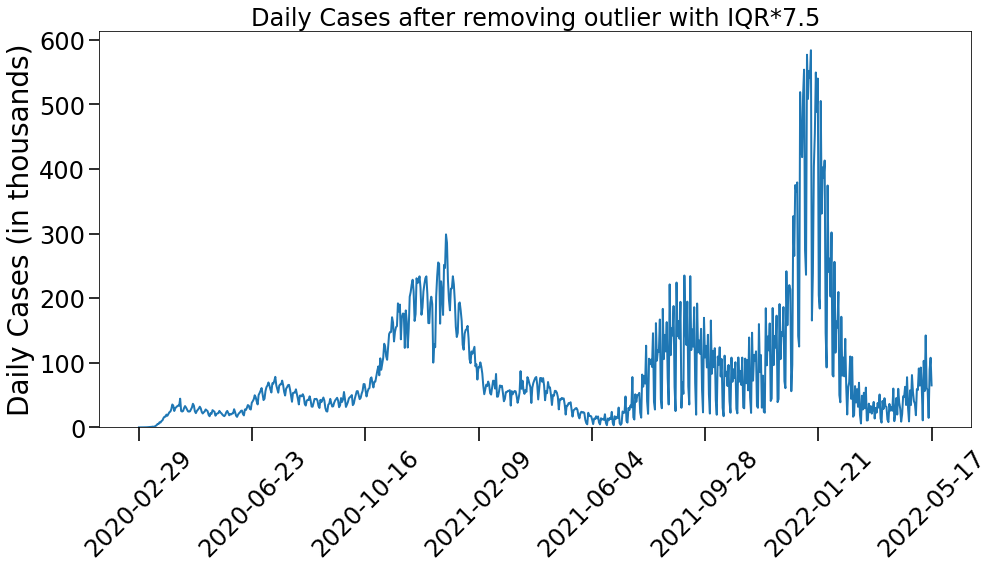

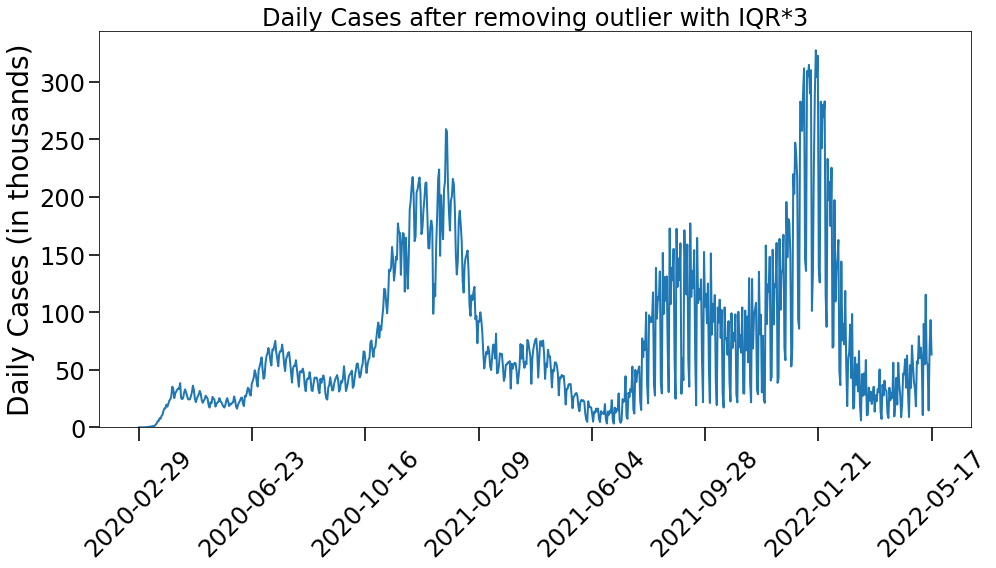

In [49]:
plot(df, feature, title=f'Raw daily {feature}', figure_name='raw_daily_cases.jpg')
plot(cleaned_0, feature, title=f'Daily {feature} after removing outlier with IQR*7.5', figure_name='cleaned_daily_cases_iqr_75.jpg')
plot(cleaned_1, feature, title=f'Daily {feature} after removing outlier with IQR*3', figure_name='cleaned_daily_cases_iqr_3.jpg')

# Combined plots

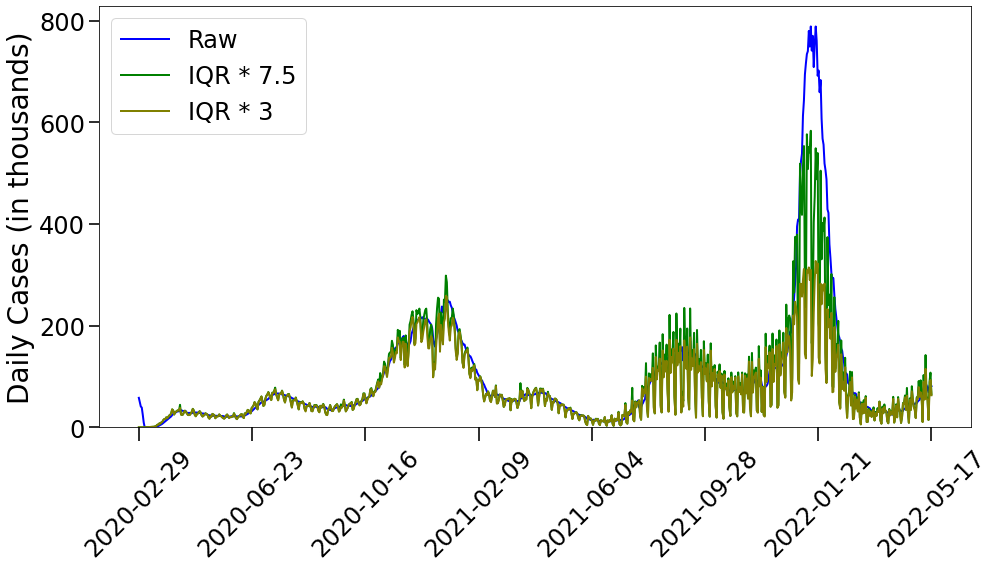

In [51]:
fig, ax = plt.subplots(figsize=FIGSIZE)
x_column = 'Date'
target = feature

plt.plot(df[x_column], df[target], color='blue', label='Raw')
plt.plot(df[x_column], cleaned_0[target], color='green', label='IQR * 7.5')
plt.plot(df[x_column], cleaned_1[target], color='olive', label='IQR * 3')
plt.ylim(bottom=0)

x_first_tick = df[x_column].min()
x_last_tick = df[x_column].max()
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (DATE_TICKS - 1) for i in range(DATE_TICKS)]
)
plt.xticks(rotation = 45)

scale_y = 1e3
if scale_y > 1:
    ax.yaxis.set_major_formatter(get_formatter(scale_y))
    
    if scale_y==1e3: unit = 'in thousands'
    elif scale_y==1e6: unit = 'in millions'
    else: unit = f'x {scale_y:.0e}'

    plt.ylabel(f'Daily {target} ({unit})')
else:
    plt.ylabel(f'Daily {target}')

plt.legend()
plt.tight_layout()

plt.show()

# Moving average

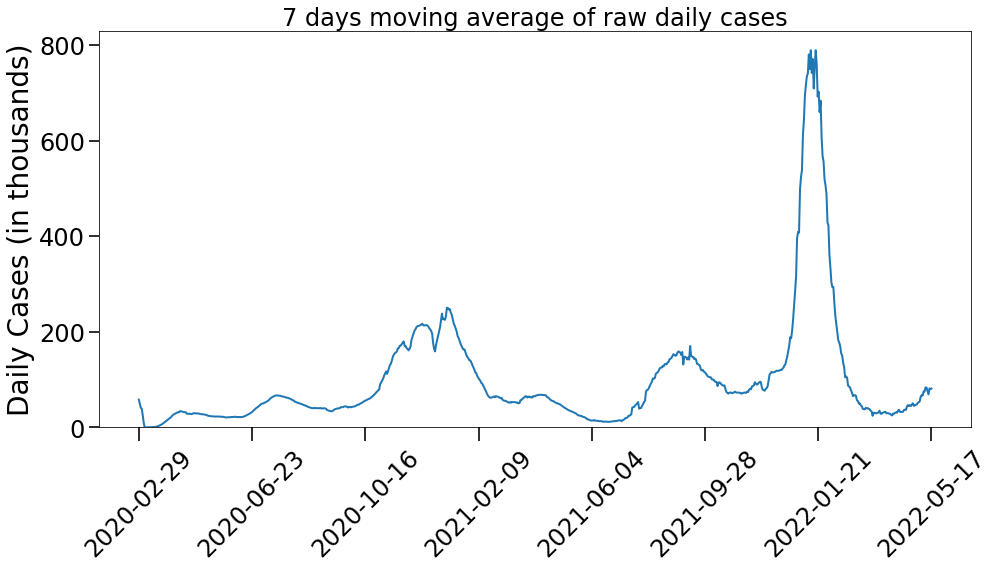

In [5]:
df = pd.read_csv('../2022_May_target_moving_averaged/Total.csv')
feature = 'Cases'
df['Date'] = pd.to_datetime(df['Date'])
df = sum_up(df)
plot(df, feature, title=f'7 days moving average of raw daily {feature.lower()}', figure_name='raw_7_days_moving_average.jpg')